In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle

print("--- Baseline Model Training ---")

# --- Step 1: Load Processed Data ---
try:
    X_train = pd.read_csv('../data/processed/X_train.csv')
    X_val = pd.read_csv('../data/processed/X_val.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel() # .values.ravel() to convert it back to a 1D array
    y_val = pd.read_csv('../data/processed/y_val.csv').values.ravel()
    print(" Processed data loaded successfully!")
except FileNotFoundError:
    print(" Error: Processed data files not found. Please run the 'data_preparation.ipynb' notebook first.")
    exit()

# --- Step 2: Load the Label Encoder ---
try:
    with open('../models/label_encoder.pkl', 'rb') as file:
        label_encoder = pickle.load(file)
    print(" Label encoder loaded successfully.")
except FileNotFoundError:
    print(" Error: label_encoder.pkl not found. Please run the 'data_preparation.ipynb' notebook first.")
    exit()

# --- Step 3: Train a Baseline Model (Random Forest) ---
print("\nTraining a Random Forest baseline model...")
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
print(" Baseline model trained successfully.")

# --- Step 4: Evaluate the Baseline Model ---
y_pred = baseline_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"\nBaseline Model Accuracy: {accuracy * 100:.2f}%")

# Print the detailed classification report
target_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=target_names))

print("\n--- Baseline Model Training Complete ---")



--- Baseline Model Training ---
 Processed data loaded successfully!
 Label encoder loaded successfully.

Training a Random Forest baseline model...
 Baseline model trained successfully.

Baseline Model Accuracy: 100.00%

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                         


--- Analyzing Feature Importance from Baseline Model ---


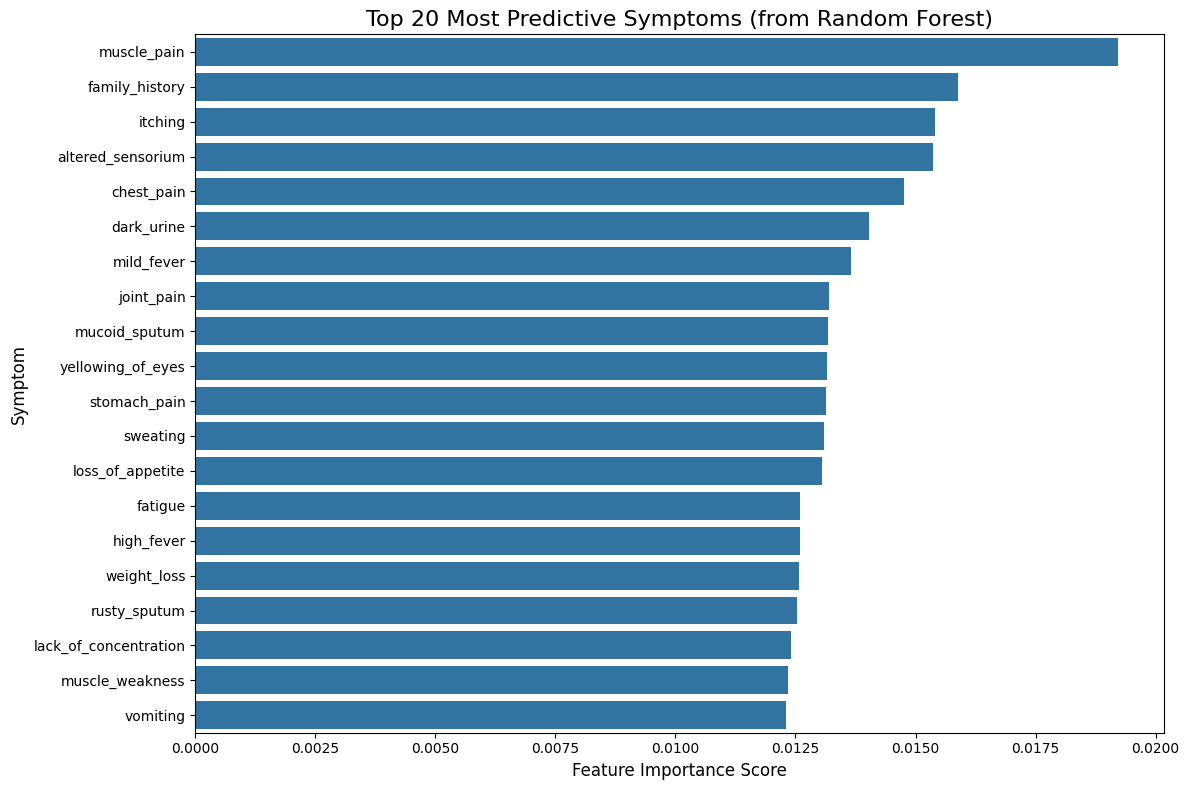


This plot shows which symptoms the model relies on most to make its predictions.
It gives a more nuanced view than simple frequency counts.


In [2]:
# --- Step 5: Analyze Feature Importance ---
# Now that our baseline model is trained, let's inspect what features (symptoms) it found most important.
print("\n--- Analyzing Feature Importance from Baseline Model ---")

# Get the feature importances from the trained RandomForestClassifier
importances = baseline_model.feature_importances_

# Create a pandas Series to make it easier to view with symptom names
feature_importance_series = pd.Series(importances, index=X_train.columns)

# Sort the features by importance in descending order
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)

# --- Visualize the Top 20 Most Important Features ---
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importance.head(20).values, y=sorted_feature_importance.head(20).index)
plt.title('Top 20 Most Predictive Symptoms (from Random Forest)', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Symptom', fontsize=12)
plt.tight_layout()
plt.show()

print("\nThis plot shows which symptoms the model relies on most to make its predictions.")
print("It gives a more nuanced view than simple frequency counts.")

#### Model Performance: Perfect Accuracy

The baseline RandomForestClassifier achieved a perfect accuracy of 100% on the validation set. This exceptional result indicates that the patterns and "symptom signatures" in the training data are so distinct and clear that the model could learn to perfectly separate all 41 diseases. While unusual in real-world scenarios, this demonstrates the high quality and clean structure of the dataset.

#### Feature Importance Analysis: Predictive Power vs. Frequency

While our initial EDA showed that general symptoms like fatigue and vomiting were the most frequent, the feature importance analysis tells a different, more insightful story.

The model identified symptoms like muscle_pain, family_history, and itching as the most predictive. This reveals a crucial insight for any data analyst: the most common feature is not always the most important one for making a prediction.

This analysis proves that the model is leveraging less frequent but highly specific symptoms to differentiate between diseases. This deeper understanding of feature predictiveness, rather than just frequency, is a key step in building an effective and interpretable model.

###  Advanced Modeling with LightGBM and Optuna

Now that we have a perfect baseline, we will build an advanced model using LightGBM, a high-performance gradient boosting framework. We will use the **Optuna** library to perform an efficient hyperparameter search to find the optimal settings for our model.

In [3]:
# Import necessary libraries for advanced modeling
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import pickle

print("--- Setting up for Hyperparameter Tuning ---")

# --- Define the Hyperparameter Tuning Objective Function ---
# This function tells Optuna what to optimize. For each 'trial', it will
# train a LightGBM model with a different set of hyperparameters and return the accuracy.

def objective(trial):
    # Define the search space for the hyperparameters we want to tune.
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
    }

    # Use Stratified K-Fold for robust validation within each trial.
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric='multi_logloss',
                  callbacks=[lgb.early_stopping(100, verbose=False)])

        preds = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, preds)
        scores.append(accuracy)

    return np.mean(scores)

print("Objective function defined. Ready to start the Optuna study.")




--- Setting up for Hyperparameter Tuning ---
Objective function defined. Ready to start the Optuna study.


Now, we will execute the hyperparameter search. Optuna will run 50 trials, intelligently exploring the hyperparameter space to find the combination that yields the highest cross-validated accuracy.

In [4]:
print("--- Starting Optuna Hyperparameter Search (50 Trials) ---")

# Create a study object and specify that we want to maximize the objective function's return value (accuracy).
study = optuna.create_study(direction='maximize')

# Start the optimization process.
study.optimize(objective, n_trials=50)

print("\n Optuna search complete! ")
print(f"Best cross-validated accuracy: {study.best_value:.4f}")
print("\nBest hyperparameters found:")
# Pretty print the best parameters
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-08-26 22:25:20,996] A new study created in memory with name: no-name-c10f2919-1220-4c5a-b1ae-2dcb76682af0


--- Starting Optuna Hyperparameter Search (50 Trials) ---


[I 2025-08-26 22:25:28,758] Trial 0 finished with value: 0.9857722895529513 and parameters: {'learning_rate': 0.25908802529784775, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 90, 'feature_fraction': 0.7201578107625761, 'bagging_fraction': 0.7215714442553653, 'bagging_freq': 4}. Best is trial 0 with value: 0.9857722895529513.
[I 2025-08-26 22:25:33,860] Trial 1 finished with value: 0.9743503247569965 and parameters: {'learning_rate': 0.2944398955422179, 'num_leaves': 35, 'max_depth': 8, 'min_child_samples': 96, 'feature_fraction': 0.7523140010299774, 'bagging_fraction': 0.5017169762145697, 'bagging_freq': 5}. Best is trial 0 with value: 0.9857722895529513.
[I 2025-08-26 22:26:09,138] Trial 2 finished with value: 0.9857722895529513 and parameters: {'learning_rate': 0.031986223749269016, 'num_leaves': 188, 'max_depth': 5, 'min_child_samples': 99, 'feature_fraction': 0.9355759063168214, 'bagging_fraction': 0.8910566444756094, 'bagging_freq': 6}. Best is trial 0 with value: 0.985


 Optuna search complete! 
Best cross-validated accuracy: 1.0000

Best hyperparameters found:
  learning_rate: 0.21124614131758604
  num_leaves: 198
  max_depth: 9
  min_child_samples: 39
  feature_fraction: 0.5938837067746465
  bagging_fraction: 0.8812701762482092
  bagging_freq: 3


With the optimal hyperparameters identified by Optuna, we will now train our final LightGBM model on the full training dataset and evaluate its performance on the validation set.

In [5]:
print("--- Training and Evaluating Final LightGBM Model ---")

# Get the best hyperparameters from the completed study.
best_params = study.best_params
# Add back the parameters that were not part of the search space.
best_params['objective'] = 'multiclass'
best_params['metric'] = 'multi_logloss'
best_params['n_jobs'] = -1
best_params['seed'] = 42
best_params['verbose'] = -1

# Train the final model on the FULL training data (X_train, y_train).
final_lgbm_model = lgb.LGBMClassifier(**best_params)
final_lgbm_model.fit(X_train, y_train)
print("\n Final LightGBM model trained successfully.")

# Evaluate the final model on the unseen validation set.
y_pred_lgbm = final_lgbm_model.predict(X_val)
final_accuracy = accuracy_score(y_val, y_pred_lgbm)

print(f"\n Final LightGBM Model Accuracy on Validation Set: {final_accuracy * 100:.2f}%")

# Save the trained model for our Flask application.
with open('../models/lgbm_model.pkl', 'wb') as file:
    pickle.dump(final_lgbm_model, file)
print("\n Final LightGBM model saved to 'models/lgbm_model.pkl'")


--- Training and Evaluating Final LightGBM Model ---

 Final LightGBM model trained successfully.

 Final LightGBM Model Accuracy on Validation Set: 100.00%

 Final LightGBM model saved to 'models/lgbm_model.pkl'
